In [ ]:
#Importing necessary libraries for the project
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your dataset zip (e.g., trash_dataset.zip)
unzip archive\ \(3\).zip -d dataset/

Saving archive (3).zip to archive (3).zip
Archive:  archive (3).zip
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_001.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_002.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_003.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_004.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_005.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_006.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_007.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_008.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_009.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_010.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_011.jpg  
  inflating: dataset/TrashType_Image_Dataset/cardboard/cardboard_012.jpg  
  inflating: dataset/TrashType_I

In [ ]:
import os
from PIL import Image
from IPython.display import display, Markdown

# Path to the dataset directory
dataset_dir = 'dataset/TrashType_Image_Dataset'

# Check if the directory exists
if not os.path.isdir(dataset_dir):
    print(f"Error: Directory '{dataset_dir}' not found. Please make sure you have unzipped the dataset correctly.")
else:
    # Get the class names from the subdirectories
    class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

    if not class_names:
        print(f"No class subdirectories found in '{dataset_dir}'.")
    else:
        # Create a markdown table header
        markdown_table = "| Class Name | Number of Images | Image Format | Dimensions |\n"
        markdown_table += "|---|---|---|---|\n"

        # Populate the table with information for each class
        for name in class_names:
            class_path = os.path.join(dataset_dir, name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            num_images = len(image_files)

            # Get image format and size from the first image
            if num_images > 0:
                first_image_path = os.path.join(class_path, image_files[0])
                try:
                    with Image.open(first_image_path) as img:
                        image_format = img.format
                        image_size = f"{img.width}x{img.height}"
                except Exception:
                    image_format = "N/A"
                    image_size = "N/A"
            else:
                image_format = "N/A"
                image_size = "N/A"

            markdown_table += f"| {name} | {num_images} | {image_format} | {image_size} |\n"

        # Display the table in the notebook
        display(Markdown(markdown_table))

| Class Name | Number of Images | Image Format | Dimensions |
|---|---|---|---|
| cardboard | 403 | JPEG | 512x384 |
| glass | 501 | JPEG | 512x384 |
| metal | 410 | JPEG | 512x384 |
| paper | 594 | JPEG | 512x384 |
| plastic | 482 | JPEG | 512x384 |
| trash | 137 | JPEG | 512x384 |


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",   # ✅ updated path
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",   # ✅ updated path
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)



Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
val_class=val_ds.class_names
print(val_class)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
val_batches=tf.data.experimental.cardinality(val_ds)
print(val_batches)



tf.Tensor(16, shape=(), dtype=int64)


In [ ]:
test_ds=val_ds.take(val_batches //2)
val_dat=val_ds.skip(val_batches //2)
test_ds_eval=test_ds.cache().prefetch(tf.data.AUTOTUNE)
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


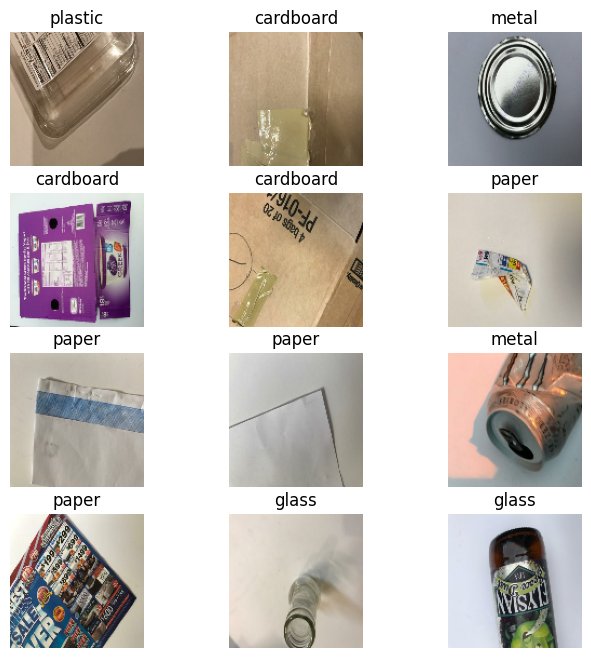

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [ ]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [ ]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [ ]:
# Ensure datasets are defined
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/TrashType_Image_Dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(124, 124),
    batch_size=32
)

# Recalculate val_batches and test_ds after re-creating val_ds
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds_split = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

class_names=train_ds.class_names
train_dist=count_distribution(train_ds,class_names)
val_dist=count_distribution(val_ds,class_names)
test_dist = count_distribution(test_ds_split, class_names)

overall_dist={}
for k in class_names:
  overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print("Training Distribution:", train_dist)
print("Validation Distribution:", val_dist)
print("Test Distribution:", test_dist)
print("Overall Distribution:", overall_dist)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Training Distribution: {'cardboard': 15.83, 'glass': 19.68, 'metal': 16.42, 'paper': 23.24, 'plastic': 19.49, 'trash': 5.34}
Validation Distribution: {'cardboard': 16.44, 'glass': 20.4, 'metal': 15.45, 'paper': 24.55, 'plastic': 17.43, 'trash': 5.74}
Test Distribution: {'cardboard': 18.36, 'glass': 21.48, 'metal': 16.02, 'paper': 24.61, 'plastic': 13.28, 'trash': 6.25}
Overall Distribution: {'cardboard': 16.14, 'glass': 20.04, 'metal': 15.94, 'paper': 23.89, 'plastic': 18.46, 'trash': 5.54}


In [ ]:
class_counts={i:0 for i in range(len(class_names))}
all_labels=[]
for images,labels in train_ds:
  for label in labels.numpy():
    class_counts[label]+=1
    all_labels.append(label)

class_weights_array=compute_class_weight(class_weight='balanced',classes=np.arange(len(class_names)),y=all_labels)
class_weights={i: w for i,w in enumerate(class_weights_array)}
print(class_counts)
print(class_weights)

{0: 320, 1: 398, 2: 332, 3: 470, 4: 394, 5: 108}
{0: np.float64(1.053125), 1: np.float64(0.8467336683417085), 2: np.float64(1.0150602409638554), 3: np.float64(0.7170212765957447), 4: np.float64(0.8553299492385786), 5: np.float64(3.1203703703703702)}


In [ ]:
data_augmentation=Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),])


In [ ]:
base_model=EfficientNetV2B2(include_top=False,weights='imagenet',input_shape=(180,180,3),include_preprocessing=False)
base_model.trainable=True
for layer in base_model.layers[:100]:
  layer.trainable=False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model=Sequential([layers.Input(shape=(124,124,3)),data_augmentation,layers.Resizing(180, 180),base_model,GlobalAveragePooling2D(),layers.Dropout(0.2),layers.Dense(len(class_names),activation='softmax')])

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
epochs=15
history=model.fit(train_ds,validation_data=val_ds,epochs=epochs,class_weight=class_weights,batch_size=32,callbacks=[early])

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 305s 5s/step - accuracy: 0.8154 - loss: 0.5251 - val_accuracy: 0.7861 - val_loss: 0.6487
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.7908 - loss: 0.5506 - val_accuracy: 0.7842 - val_loss: 0.6676
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.8138 - loss: 0.5037 - val_accuracy: 0.8040 - val_loss: 0.6063
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 326s 5s/step - accuracy: 0.8237 - loss: 0.4553 - val_accuracy: 0.8198 - val_loss: 0.5832
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.8341 - loss: 0.4575 - val_accuracy: 0.7921 - val_loss: 0.6113
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 305s 4s/step - accuracy: 0.8294 - loss: 0.4474 - val_accuracy: 0.7762 - val_loss: 0.6544
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 303s 5s/step - accuracy: 0.8509 - loss: 0.4051 - val_accuracy: 0.7881 - val_loss: 0.6430
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.8646 - loss: 0.3654 - val_accuracy: 0.7842 - v

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 6, 6, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [ ]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 90, 90,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 90, 90,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 90, 90,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 90, 90,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 90, 90,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 90, 90,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 90, 90,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 90, 90,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 90, 90,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 90, 90,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 90, 90,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 45, 45,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 45, 45,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 45, 45,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 45, 45,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 45, 45,    │        128 │ block2a_project_

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(len(acc))


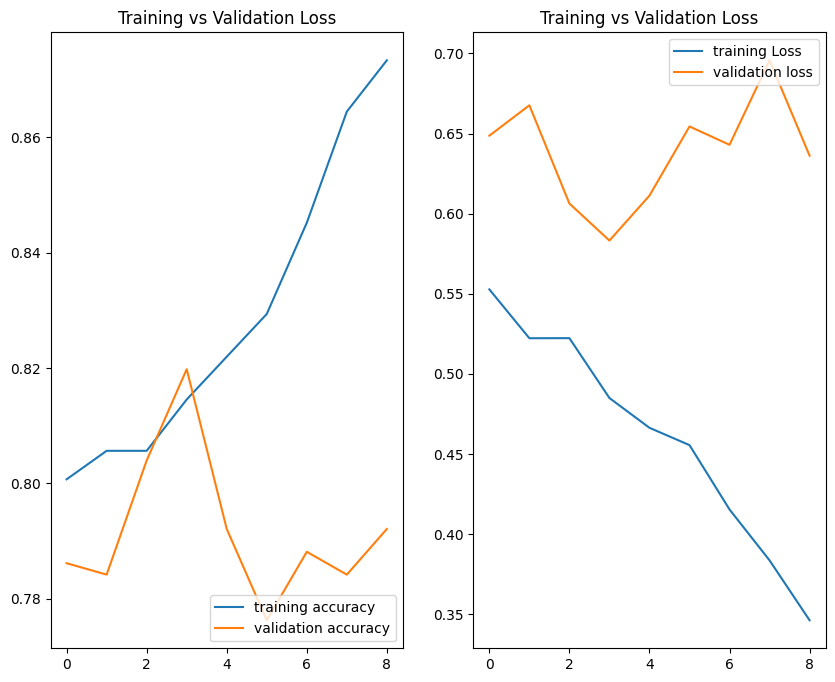

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='training accuracy')
plt.plot(epochs_range,val_acc,label='validation accuracy')
plt.legend(loc='lower right')
plt.title("Training vs Validation Loss")

plt.subplot(1,2,2)

plt.plot(epochs_range,loss, label='training Loss')
plt.plot(epochs_range,val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title("Training vs Validation Loss")
plt.show() #display the graphs

In [ ]:
loss,accuracy=model.evaluate(test_ds_eval)
print(f'Test Accuracy :{accuracy:.4f}, Test Loss :{loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8471 - loss: 0.4987
Test Accuracy :0.8281, Test Loss :0.5611


In [ ]:
# Extract true labels from all batches in the test dataset
y_true=np.concatenate([y.numpy() for x,y in test_ds_eval],axis=0) #Convert Tensor labels to NumPy array and concatenate them
#get predictions as probabilities from the model
y_pred_probs=model.predict(test_ds_eval)#predict class probabilities for each sample in dataset
#convert probabilities to predicted class indices
y_pred=np.argmax(y_pred_probs,axis=1)#select the class with the highest probability for each sample
cm = confusion_matrix(y_true, y_pred)
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class


8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
[[32  0  1  2  3  2]
 [ 1 50  1  0  4  0]
 [ 0  6 29  1  1  2]
 [ 0  1  0 55  1  6]
 [ 1  7  2  2 30  0]
 [ 0  0  0  0  0 16]]
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        40
           1       0.78      0.89      0.83        56
           2       0.88      0.74      0.81        39
           3       0.92      0.87      0.89        63
           4       0.77      0.71      0.74        42
           5       0.62      1.00      0.76        16

    accuracy                           0.83       256
   macro avg       0.82      0.84      0.82       256
weighted avg       0.84      0.83      0.83       256



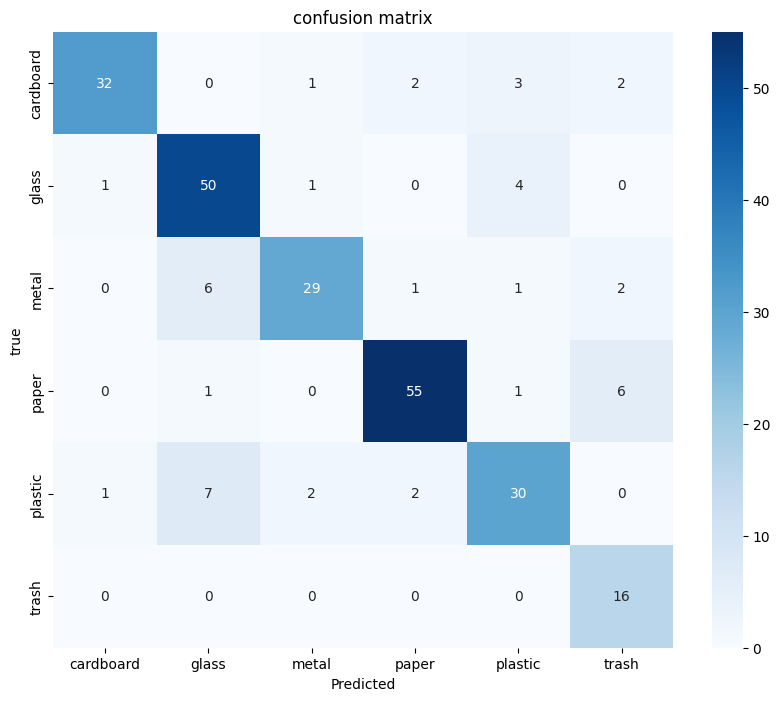

In [ ]:
#plotting the confusion matrix to visualize model performance
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('true')
plt.title('confusion matrix')
plt.show() #display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


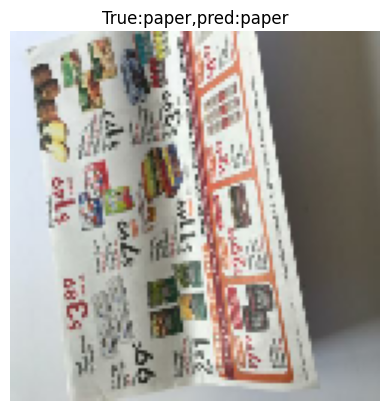

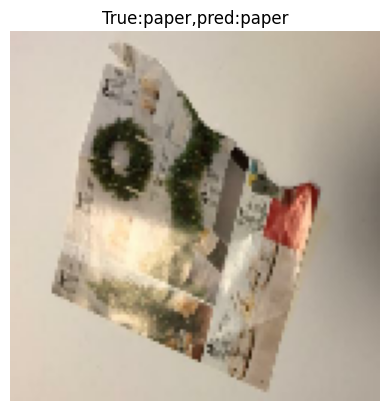

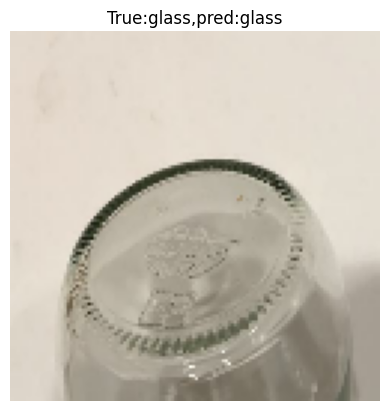

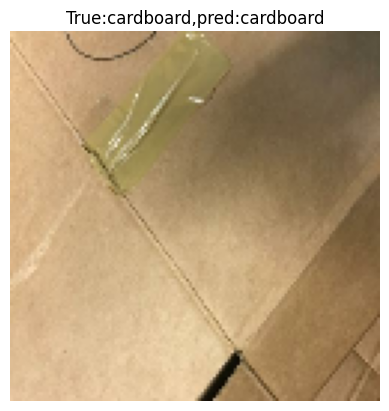

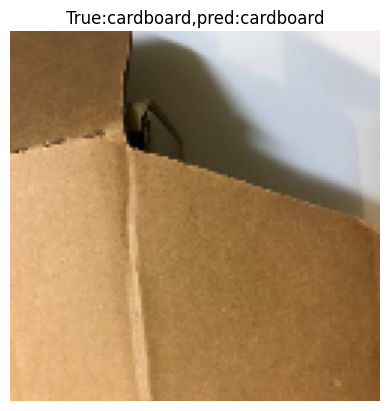

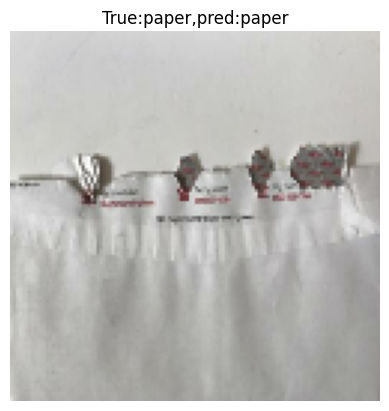

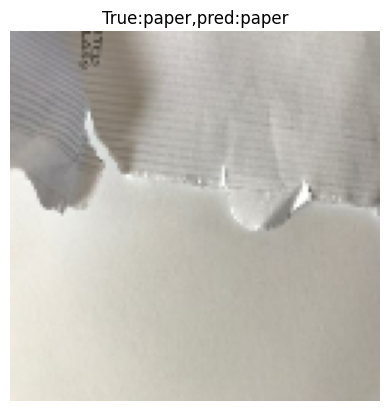

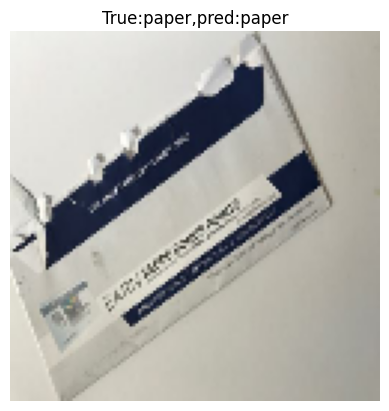

In [ ]:
class_names=train_ds.class_names #extract class names
for images,labels in test_ds_eval.take(1):
  predictions=model.predict(images)
  pred_labels=tf.argmax(predictions,axis=1)
  for i in range(8):
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"True:{class_names[labels[i]]},pred:{class_names[pred_labels[i]]}")
    plt.axis("off")
    plt.show()

In [ ]:
model.save('Effiicientnetv2b2.keras') # saving the model

In [ ]:
from google.colab import files
files.download('Effiicientnetv2b2.keras') #downloading the model file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model('Effiicientnetv2b2.keras') #load the model

In [ ]:
print(accuracy)

0.828125


In [ ]:
!pip install gradio

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
def classify_image(img):
    # Resize image to 124x124 pixels (Note: Comment says 128x128, but code resizes to 124x124)
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"


In [ ]:
import gradio as gr
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# A function to classify the image
def classify_image(img):
    # Resize image to 124x124 pixels
    img = img.resize((124, 124))

    # Convert image to a NumPy array with float32 dtype
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)

    # Expand dimensions to match model input shape (adds a batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction using the trained model
    prediction = model.predict(img_array)

    # Get the index of the highest predicted probability
    predicted_class_index = np.argmax(prediction)

    # Map the predicted index to its corresponding class name
    predicted_class_name = class_names[predicted_class_index]

    # Extract confidence score (probability of the predicted class)
    confidence = prediction[0][predicted_class_index]

    # Return formatted prediction result with confidence score
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"

# Create the Gradio interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload an image of trash"),
    outputs="text",
    title="Trash Classifier",
    description="This app classifies images of trash into one of six categories: cardboard, glass, metal, paper, plastic, or trash.",
    examples=[
        ["dataset/TrashType_Image_Dataset/cardboard/cardboard_001.jpg"],
        ["dataset/TrashType_Image_Dataset/glass/glass_001.jpg"],
        ["dataset/TrashType_Image_Dataset/metal/metal_001.jpg"],
    ],
    theme="huggingface"
)

# Launch the interface
iface.launch(share=True)

/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1195: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-688a62fb-0aabaa6b1d5dca7a64ca6310;c1e58ddf-aa4a-45f7-a16d-dd2c1014bf41)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://081afaf84b8421793c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


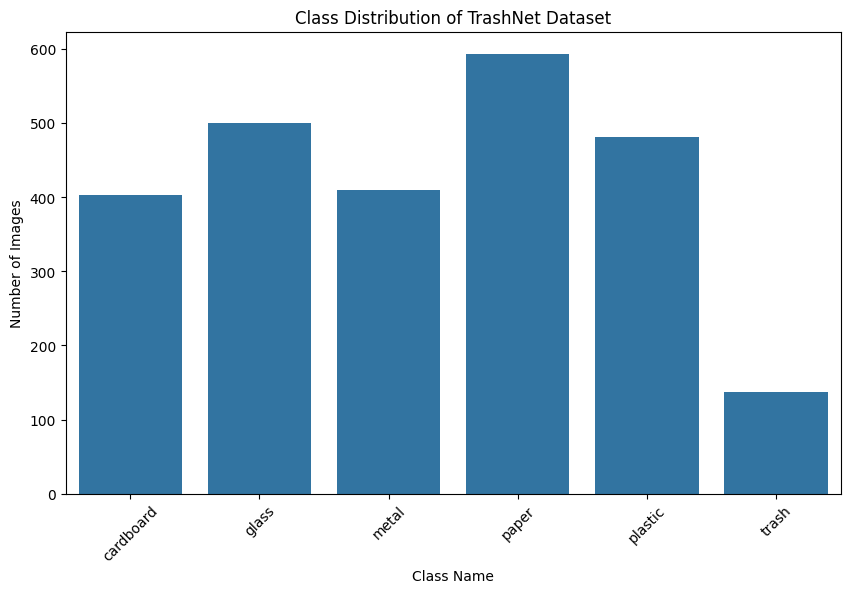

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot of the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Class Distribution of TrashNet Dataset')
plt.xticks(rotation=45)
plt.show()

### Step 1: Create a Hugging Face Account

If you don't have one already, go to [huggingface.co/join](https://huggingface.co/join) and create a free account.

### Step 2: Get Your Hugging Face API Token

You'll need a token with "write" permissions to upload your model.
1.  Go to your Hugging Face profile settings.
2.  Click on "Access Tokens" in the left menu.
3.  Click "New token", give it a name (e.g., "Colab Notebook"), and select the **write** role.
4.  Copy the generated token. You'll need it in the next step.

In [ ]:
# Install the library needed to interact with the Hugging Face Hub
!pip install huggingface_hub -q

from huggingface_hub import HfApi, HfFolder, create_repo, notebook_login

# Login to Hugging Face
# You will be prompted to paste your token here.
notebook_login()

# --- IMPORTANT ---
# Define your Hugging Face username and a name for your new model repository.
# Replace "YOUR_USERNAME" with your actual Hugging Face username.
HF_USERNAME = "YOUR_USERNAME"
REPO_NAME = "trash-classifier-efficientnet"
REPO_ID = f"{HF_USERNAME}/{REPO_NAME}"

print(f"Your repository ID is: {REPO_ID}")

# Create the model repository on the Hub
try:
    create_repo(repo_id=REPO_ID, exist_ok=True)
    print(f"Repository '{REPO_ID}' created or already exists.")
except Exception as e:
    print(f"Error creating repository: {e}")

# Save your trained model to a file
model.save('trash_classifier_model.keras')

# Upload the model file to your new repository
api = HfApi()
try:
    api.upload_file(
        path_or_fileobj="trash_classifier_model.keras",
        path_in_repo="trash_classifier_model.keras", # The name of the file in the repo
        repo_id=REPO_ID,
        repo_type="model"
    )
    print(f"Model uploaded successfully to: https://huggingface.co/{REPO_ID}")
except Exception as e:
    print(f"Error uploading model: {e}")



Your repository ID is: YOUR_USERNAME/trash-classifier-efficientnet
Error creating repository: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-688a63b0-5b4455f81f1d4e502156ce44;1b61c85c-bcb1-42ef-888c-b74b7821eac7)

Invalid username or password.
Error uploading model: 401 Client Error. (Request ID: Root=1-688a63b2-08d3d30664e3d81714e37495;0a680db0-48f3-4061-a7c3-3f70e6e508b1)

Repository Not Found for url: https://huggingface.co/api/models/YOUR_USERNAME/trash-classifier-efficientnet/preupload/main.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.
Note: Creating a commit assumes that the repo already exists on the Huggingface Hub. Please use `create_repo` if it's not the case.


### Step 4: Create the Application Files

For deployment, you need two text files: `app.py` (your Gradio code) and `requirements.txt` (the libraries your app needs). You don't need to create these in Colab, but you will copy and paste the content below into your Hugging Face Space.

---

**1. Content for `app.py`**

This code will run your Gradio app. It loads the model you just uploaded.

```python
import gradio as gr
import numpy as np
from PIL import Image
import tensorflow as tf
from huggingface_hub import from_pretrained_keras

# --- IMPORTANT ---
# Make sure this REPO_ID matches the one you created in Step 3
REPO_ID = "YOUR_USERNAME/trash-classifier-efficientnet"

# Load the model from the Hugging Face Hub
try:
    model = from_pretrained_keras(REPO_ID, custom_objects={"TFSMLayer": tf.keras.layers.TFSMLayer})
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

def classify_image(img):
    if model is None:
        return {"Error": "Model could not be loaded."}
    
    # Preprocess the image
    img = img.resize((124, 124))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)[0]
    
    # Format the output
    confidences = {class_names[i]: float(prediction[i]) for i in range(len(class_names))}
    return confidences

# Create the Gradio interface with gr.Blocks
with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal")) as iface:
    gr.Markdown("# ♻️ Trash Classifier App")
    gr.Markdown("Upload an image of trash, and the model will classify it into one of six categories.")

    with gr.Row(variant="panel"):
        with gr.Column(scale=1):
            image_input = gr.Image(type="pil", label="Upload Image")
            submit_button = gr.Button("Classify Image", variant="primary")
        with gr.Column(scale=1):
            gr.Markdown("## Prediction Results")
            output_label = gr.Label(num_top_classes=3, label="Classification")

    submit_button.click(
        fn=classify_image,
        inputs=image_input,
        outputs=output_label
    )
    
    gr.Markdown("---")
    gr.Markdown("### Example Images")
    gr.Examples(
        examples=[
            "https://i.imgur.com/3qVjWd1.jpeg", # Cardboard
            "https://i.imgur.com/3aV0T5A.jpeg", # Glass
            "https://i.imgur.com/fplxTjD.jpeg"  # Metal
        ],
        inputs=image_input
    )

iface.launch()
```

---

**2. Content for `requirements.txt`**

This file lists the required Python libraries.

```
tensorflow
gradio
numpy
Pillow
huggingface_hub
```
---
### Step 5: Create and Deploy on Hugging Face Spaces

1.  Go to [huggingface.co/new-space](https://huggingface.co/new-space).
2.  Give your Space a **name** (e.g., `trash-classifier`).
3.  Select a **license**, such as `MIT`.
4.  For the **Space SDK**, select **Gradio**.
5.  Choose **Public** visibility.
6.  Click **Create Space**.
7.  You'll be taken to your new Space. Click the **Files** tab.
8.  Click **Add file** and select **Create new file**.
9.  Name the file `requirements.txt`. Copy the text from `requirements.txt` above, paste it into the editor, and click **Commit new file**.
10. Click **Add file** again and **Create new file**.
11. Name this file `app.py`. Copy the Python code for `app.py` from above.
12. **Crucially, remember to replace `YOUR_USERNAME/trash-classifier-efficientnet` with your actual model repository ID in the `app.py` code.**
13. Click **Commit new file**.

That's it! Hugging Face will automatically build your application. After a minute or two, your permanent Gradio app will be live under the "App" tab. You can now share the URL of your Space with anyone.